In [2]:
import glob

In [3]:
import tensorflow

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
%matplotlib inline

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
import cv2

from sklearn import svm
import joblib

## <font color='black'> Collecting dataset </font>

In [41]:
def create_dataframe(images_path):
    data=[]
    labels=[]
    classes=10
    for i in range(classes):
        img_path=os.path.join(images_path,str(i))
        for img in os.listdir(img_path):
            im=cv2.imread(images_path+'/'+str(i)+'/'+img)
            im= cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
            _, des = sift.detectAndCompute(im, None)
            #reshape_feature = des.reshape(-1, des.shape[0]*des.shape[1])
            #im = np.array(im)
            data.append(des)
            labels.append(i)
    data = np.array(data)
    labels = np.array(labels)
    return data,labels

In [62]:
def calcSiftFeature(img):
         #Set image sift feature key points to a maximum of 200

    sift = cv2.xfeatures2d.SIFT_create()
         #Calculate the feature points and feature point description of the picture
    keypoints, features = sift.detectAndCompute(img, None)
    return features

In [63]:
#Calculation word bag
def learnVocabulary(features):
    wordCnt = 50
    #criteria indicates the mode of iteration stop eps --- precision 0.1, max_iter --- meet more than the maximum number of iterations 20
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 20, 0.1)
    #Get the initial center point of k-means clustering
    flags = cv2.KMEANS_RANDOM_CENTERS
    # Label, center = kmeans(input data (feature), number of clusters K, preset label, cluster stop condition, number of repeated clusters, initial cluster center point
    compactness, labels, centers = cv2.kmeans(features, wordCnt, None,criteria, 20, flags)
    return centers

In [64]:
#Calculate feature vector
def calcFeatVec(features, centers):
    featVec = np.zeros((1, 50))
    for i in range(0, features.shape[0]):
        #The characteristic point of the i-th picture
        fi = features[i]
        diffMat = np.tile(fi, (50, 1)) - centers
        #axis=1Sum by line, that is, the distance between the feature and each center point
        sqSum = (diffMat**2).sum(axis=1)
        dist = sqSum**0.5
        #Ascending order
        sortedIndices = dist.argsort()
        #Remove the smallest distance, that is, find the nearest center point
        idx = sortedIndices[0]
        #The center point corresponds to +1
        featVec[0][idx] += 1
    return featVec

In [47]:
img_f=cv2.imread('Dataset/Train/0/122.jpg')
img_f = calcSiftFeature(img)

In [48]:
img_f.shape

(128,)

In [70]:
#Build word bags
def build_center(path):
    cate=[path+'/'+x for x in os.listdir(path) if os.path.isdir(path+'/'+x)]
    features = np.float32([]).reshape(0, 128)#Store features of training set pictures
    for idx,folder in enumerate(cate):
        for im in glob.glob(folder+'/*.jpg'):
            img=cv2.imread(im)
            
            #Get picture sift feature points
            img_f = calcSiftFeature(img)
            #Feature points join training data
            #print(img_f.shape,features.shape)
            
            features = np.append(features, img_f, axis=0)
    #Training set of word bags
    centers = learnVocabulary(features)
    #Save the word bag
    filename = "Dataset/svm_centers.npy"
    np.save(filename, centers)
    print('Word bag:',centers.shape)

In [71]:
def cal_vec(path):
    centers = np.load("Dataset/svm_centers.npy")
    data_vec = np.float32([]).reshape(0, 50)#Store features of training set pictures
    labels = np.float32([])
    cate=[path+'/'+x for x in os.listdir(path) if os.path.isdir(path+'/'+x)]
    for idx,folder in enumerate(cate):
        for im in glob.glob(folder+'/*.jpg'):
            #print('reading the images:%s'%(im))#im indicates the path of an image
            img=cv2.imread(im)
            #Get picture sift feature points
            img_f = calcSiftFeature(img)
            img_vec = calcFeatVec(img_f, centers)
            data_vec = np.append(data_vec,img_vec,axis=0)
            labels = np.append(labels,idx)
    print('data_vec:',data_vec.shape)
    print('image features vector done!')
    return data_vec,labels

In [82]:
def SVM_Train(data_vec,labels):
    #Set SVM model parameters
    clf = svm.SVC(decision_function_shape='ovo')
    #Use x_train, y_train to train the SVM classifier and obtain the parameters
    clf.fit(data_vec,labels)
    joblib.dump(clf, "Dataset/svm_model.m")

In [92]:
def SVM_Test(path):
    #Read SVM model
    clf = joblib.load("Dataset/svm_model.m")
    #Read the word bag
    centers = np.load("Dataset/svm_centers.npy")
    #Calculate the feature vector of each picture
    data_vec,labels = cal_vec(path)
    res = clf.predict(data_vec)
    num_test = data_vec.shape[0]
    acc = 0
    for i in range(num_test):
        if labels[i] == res[i]:
            acc = acc+1
    return acc/num_test,res

In [75]:
def create_dataframe(images_path):
    data=[]
    labels=[]
    classes=10
    for i in range(classes):
        img_path=os.path.join(images_path,str(i))
        for img in os.listdir(img_path):
            #im=cv2.imread(images_path+'/'+str(i)+'/'+img)
            #im= remove_background(im)
            #im = np.array(im)
            #data.append(im)
            labels.append(i)
    #data = np.array(data)
    labels = np.array(labels)
    return labels

In [107]:
from numpy import load
y_train=load('labels.npy')

In [103]:
train_path = 'Train_GRAY'
test_path = 'Test_GRAY'
#Build word bags
build_center(train_path)
#Build training set feature vector
data_vec,labels = cal_vec(train_path)

Word bag: (50, 128)
data_vec: (3600, 50)
image features vector done!


In [104]:
from numpy import save
save('SIFT_Features.npy',data_vec)
save('SIFT_labels.npy',y_train)

In [ ]:
save('SIFT_test',)

In [108]:
#Input feature vector and label into SVM classifier
SVM_Train(data_vec,y_train)



In [109]:
data_vec,labels = cal_vec(test_path)

data_vec: (401, 50)
image features vector done!


In [111]:
data_vec,_,labels,_=train_test_split(data_vec,labels, test_size=0.001, random_state=42)

In [115]:
from numpy import save
save('SIFT_test_Features.npy',data_vec)
save('SIFT_test_labels.npy',labels)

In [166]:
#Calculate the correct rate of the test set
acc,res = SVM_Test(test_path)
print(acc)

data_vec: (401, 50)
image features vector done!
0.885286783042394


In [ ]:
x_train=load('SIFT_Features.npy')
x_test=

In [118]:
x_train= x_train[..., np.newaxis]
x_test=x_test[..., np.newaxis]

NameError: name 'x_train' is not defined

(120, 160, 3)

In [14]:
img=cv2.imread('Dataset/Train/0/370.jpg')

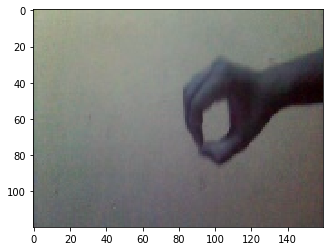

In [15]:
plt.imshow(img)

In [162]:
sift = cv2.xfeatures2d.SIFT_create()
         #Calculate the feature points and feature point description of the picture
keypoints, features = sift.detectAndCompute(img, None)

In [163]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [164]:

img = cv2.drawKeypoints(gray,keypoints,img)

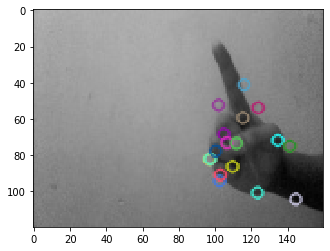

In [165]:
plt.imshow(img)

In [48]:
img=cv2.imread('Dataset/Train/0/35.jpg')

In [49]:
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [75]:
thresh = cv2.adaptiveThreshold(img_gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,133,5)

In [67]:
_, thresh = cv2.threshold(img_gray, 120, 255, cv2.THRESH_BINARY_INV)

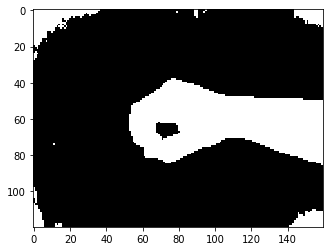

In [80]:
plt.imshow(thresh,cmap='gray')

In [81]:
image=img
contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
                                    
# draw contours on the original image
image_copy = image.copy()
cv2.drawContours(image=image_copy, contours=contours, contourIdx=-1, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

array([[[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 54, 205,  51],
        ...,
        [ 61, 207,  59],
        [  0, 255,   0],
        [  0, 255,   0]],

       ...,

       [[  0, 255,   0],
        [  0, 255,   0],
        [ 83, 223,  71],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]],

       [[  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0],
        ...,
        [  0, 255,   0],
        [  0, 255,   0],
        [  0, 255,   0]]

In [70]:
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw all contours
image = cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

In [85]:
contours1, hierarchy1 = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image for `CHAIN_APPROX_SIMPLE`
image_copy1 = image.copy()
cv2.drawContours(image_copy1, contours1, -1, (0, 255, 0), 2, cv2.LINE_AA)


array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,  79, ...,  90,   0,   0],
       ...,
       [  0,   0, 109, ...,  94,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0,   0,   0]], dtype=uint8)

In [83]:
#image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

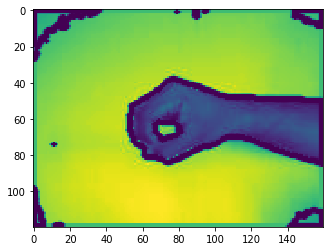

In [87]:
plt.imshow(image_copy1)#,cmap='gray')

In [88]:
def remove_background(img):
    #img1 = rgb2gray(img)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = img
    #blur = cv2.GaussianBlur(img1,(3,3),0)
    #ret,thresh1 = cv2.threshold(img1,225,255,cv2.THRESH_BINARY_INV)
    thresh1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,133,5)
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(thresh1, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    b,g,r = cv2.split(img2)
    for i in range(closing.shape[0]):
      for j in range(closing.shape[1]):
        if(closing[i,j])==0:
          b[i,j] = 0
          g[i,j] = 0
          r[i,j] = 0

    newimg = cv2.merge((b,g,r))
    
    newimg=cv2.cvtColor(newimg, cv2.COLOR_BGR2GRAY)
    return newimg

In [112]:
def remove_background_new(img):
    #img1 = rgb2gray(img)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img2 = img
    #blur = cv2.GaussianBlur(img1,(3,3),0)
    #ret,thresh1 = cv2.threshold(img1,225,255,cv2.THRESH_BINARY_INV)
    thresh1 = cv2.adaptiveThreshold(img1,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,133,5)
    
    contours1, hierarchy1 = cv2.findContours(thresh1, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# draw contours on the original image for `CHAIN_APPROX_SIMPLE`
    image_copy1 = image.copy()
    cv2.drawContours(image_copy1, contours1, -1, (0, 255, 0), 2, cv2.LINE_AA)
    newimg=image_copy1
    #newimg=cv2.cvtColor(newimg, cv2.COLOR_BGR2GRAY)
    return newimg

In [113]:
img=cv2.imread('Dataset/Train/0/10.jpg')

In [114]:
nn=remove_background(img)

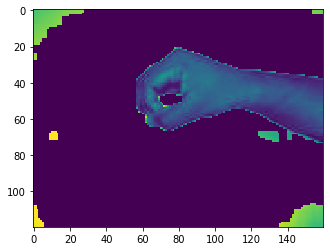

In [115]:
plt.imshow(nn)

In [116]:
nn1=remove_background_new(img)

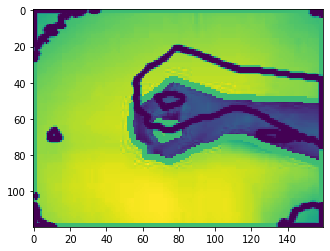

In [117]:
plt.imshow(nn1)